<a href="https://colab.research.google.com/github/sat0304/alpha_credit/blob/main/alphabank_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Кредитный скоринг на данных кредитных историй
Кредитный скоринг – важнейшая банковская задача. Стандартным подходом к ее решению является построение классических моделей машинного обучения, таких как логистическая регрессия и градиентный бустинг, на табличных данных, в том числе используя агрегации от каких-нибудь последовательных данных, например, транзакционных историй клиентов. Альтернативный подход заключается в использовании последовательных данных “как есть”, подавая их на вход рекуррентной нейронной сети.

В этом соревновании участникам предлагается решить задачу кредитного скоринга клиентов Альфа-Банка, используя только данные кредитных историй.

Датасет соревнования устроен таким образом, что кредиты для тренировочной выборки взяты за период в М месяцев, а кредиты для тестовой выборки взяты за последующие K месяцев.

Каждая запись кредитной истории содержит самую разнообразную информацию о прошлом кредите клиента, например, сумму, отношение клиента к кредиту, дату открытия и закрытия, информацию о просрочках по платежам и др. Все публикуемые данные тщательно анонимизированы.

Целевая переменная – бинарная величина, принимающая значения 0 и 1, где 1 соответствует дефолту клиента по кредиту.

In [ ]:
# Импортируем библиотеки numpy и pandas для работы с матрицами
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Запишем названия наших столбцов в массив
column_names =  [
    'id',
    'rn',
    'pre_since_opened',
    'pre_since_confirmed',
    'pre_pterm',
    'pre_fterm',
    'pre_till_pclose',
    'pre_till_fclose',
    'pre_loans_credit_limit',
    'pre_loans_next_pay_summ',
    'pre_loans_outstanding',
    'pre_loans_total_overdue',
    'pre_loans_max_overdue_sum',
    'pre_loans_credit_cost_rate',
    'pre_loans5',
    'pre_loans530',
    'pre_loans3060',
    'pre_loans6090',
    'pre_loans90',
    'is_zero_loans5',
    'is_zero_loans530',
    'is_zero_loans3060',
    'is_zero_loans6090',
    'is_zero_loans90',
    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit',
    'is_zero_util',
    'is_zero_over2limit',
    'is_zero_maxover2limit',
    'enc_paym_0',
    'enc_paym_1',
    'enc_paym_2',
    'enc_paym_3',
    'enc_paym_4',
    'enc_paym_5',
    'enc_paym_6',
    'enc_paym_7',
    'enc_paym_8',
    'enc_paym_9',
    'enc_paym_10',
    'enc_paym_11',
    'enc_paym_12',
    'enc_paym_13',
    'enc_paym_14',
    'enc_paym_15',
    'enc_paym_16',
    'enc_paym_17',
    'enc_paym_18',
    'enc_paym_19',
    'enc_paym_20',
    'enc_paym_21',
    'enc_paym_22',
    'enc_paym_23',
    'enc_paym_24',
    'enc_loans_account_holder_type',
    'enc_loans_credit_status',
    'enc_loans_account_cur',
    'enc_loans_credit_type',
    'pclose_flag',
    'fclose_flag'
]

In [ ]:
column_to_drop =  [
    'pre_loans_total_overdue',
    'is_zero_over2limit',
    'is_zero_loans3060',
    'enc_paym_1',
    'enc_paym_2',
    'enc_paym_4',
    'enc_paym_5',
    'enc_paym_6',
    'enc_paym_7',
    'enc_paym_8',
    'enc_paym_10',
    'enc_paym_11',
    'enc_paym_12',
    'enc_paym_13',
    'enc_paym_14',
    'enc_paym_15',
    'enc_paym_16',
    'enc_paym_18',
    'enc_paym_19',
    'enc_paym_20',
    'enc_paym_21',
    'enc_paym_22',
    'enc_paym_23',
    'enc_paym_24',
]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



##Processing Data



---



In [ ]:
# Загрузим данные при помощи фукции read_parquet библиотеки pandas по ссылке
# дополнительно укажем названия столбцов
df_0 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_0.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

# Посмотрим на наш датасет

In [ ]:
df_0

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,1,4,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,1,4,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,1,3,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974719,249998,4,1,9,14,8,10,11,8,4,...,3,3,3,4,1,2,1,3,0,1
1974720,249998,5,7,9,4,8,1,11,19,1,...,3,3,3,4,1,2,1,4,1,1
1974721,249999,1,9,0,10,8,10,11,16,2,...,3,3,3,4,1,2,1,3,0,1
1974722,249999,2,9,16,10,13,10,4,12,2,...,3,3,3,4,1,2,1,3,0,0


In [ ]:
df_0 = df_0.drop(columns=column_to_drop)

In [ ]:
df_0_mean = df_0.groupby('id').mean().reset_index()

In [ ]:
df_0

In [ ]:
df_1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_1.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_1 = df_1.drop(columns=column_to_drop)

In [ ]:
df_1_mean = df_1.groupby('id').mean().reset_index()

In [ ]:
df_1

In [ ]:
df_2 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_2.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_2 = df_2.drop(columns=column_to_drop)

In [ ]:
df_2_mean = df_2.groupby('id').mean().reset_index()

In [ ]:
df_3 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_3.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_3 = df_3.drop(columns=column_to_drop)

In [ ]:
df_3_mean = df_3.groupby('id').mean().reset_index()

In [ ]:
df_4 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_4.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_4 = df_4.drop(columns=column_to_drop)

In [ ]:
df_4_mean = df_4.groupby('id').mean().reset_index()

In [ ]:
df_5 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_5.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_5 = df_5.drop(columns=column_to_drop)

In [ ]:
df_5_mean = df_5.groupby('id').mean().reset_index()

In [ ]:
df_6 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_6.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_6 = df_6.drop(columns=column_to_drop)

In [ ]:
df_6_mean = df_6.groupby('id').mean().reset_index()

In [ ]:
df_7 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_7.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_7 = df_7.drop(columns=column_to_drop)

In [ ]:
df_7_mean = df_7.groupby('id').mean().reset_index()

In [ ]:
df_8 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_8.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_8 = df_8.drop(columns=column_to_drop)

In [ ]:
df_8_mean = df_8.groupby('id').mean().reset_index()

In [ ]:
df_9 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_9.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_9 = df_9.drop(columns=column_to_drop)

In [ ]:
df_9_mean = df_9.groupby('id').mean().reset_index()

In [ ]:
df_10 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_10.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_10 = df_10.drop(columns=column_to_drop)

In [ ]:
df_10_mean = df_10.groupby('id').mean().reset_index()

In [ ]:
df_11 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/train_data_11.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_11 = df_11.drop(columns=column_to_drop)

In [ ]:
df_11_mean = df_11.groupby('id').mean().reset_index()

In [ ]:
# Посмотрим есть ли в нашем датасете пропуски при помощи метода info

df_0.isna().sum().head(60)

In [ ]:
# Посмотрим на число уникальных значений в каждом из столбцов при помощи метода nunique()
df_0.nunique().head(60)

In [ ]:
df_0['rn'].nunique()

51

In [ ]:
df_0['rn'].value_counts()

<Axes: >

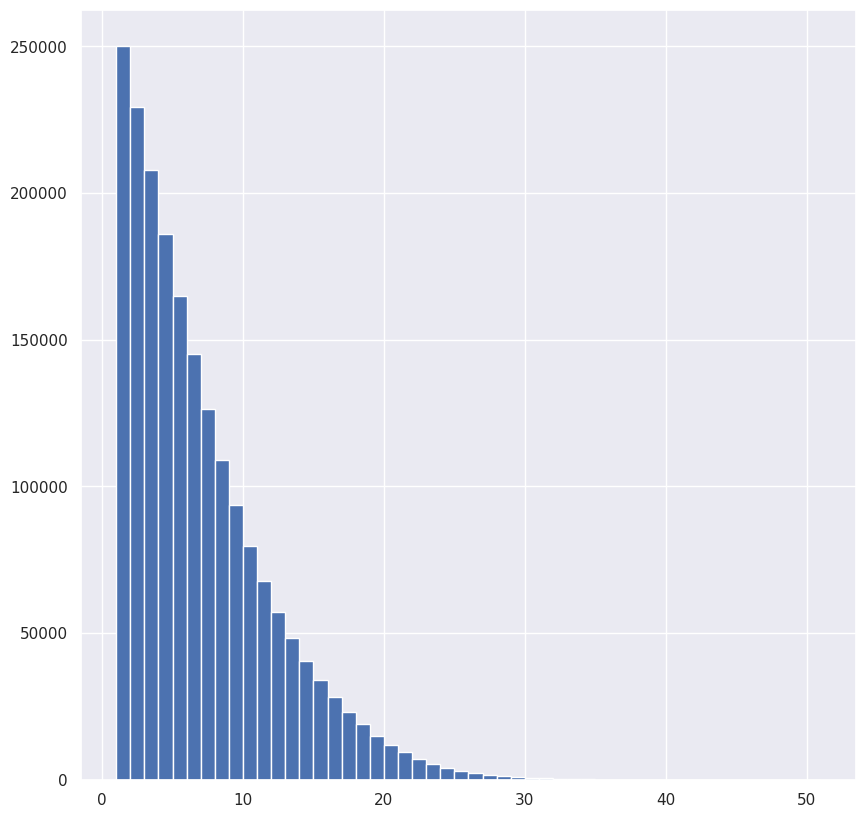

In [ ]:
sns.set()

# Построим гистограммы наших данных с числом бинов 50
df_0['rn'].hist(bins=50, figsize=(10, 10))

In [ ]:
df_0['rn'].describe()

count    1.974724e+06
mean     6.537471e+00
std      5.121167e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      5.100000e+01
Name: rn, dtype: float64

In [ ]:
print(df_0.shape)
# , df_1.shape, df_2.shape, df_3.shape, df_4.shape, df_5.shape)

(1974724, 37)


In [ ]:
df_0_mean

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
0,0,5.5,8.100000,7.600000,7.100000,7.500000,11.400000,10.700000,9.600000,3.100000,...,0.100000,0.600000,1.500000,2.100000,1.0,2.600000,1.000000,3.500000,0.100000,0.200000
1,1,7.5,11.428571,7.642857,6.642857,7.928571,10.071429,7.000000,8.142857,2.142857,...,0.285714,0.642857,1.428571,2.142857,1.0,2.714286,1.000000,3.142857,0.071429,0.142857
2,2,2.0,8.333333,10.666667,7.000000,6.000000,5.000000,9.000000,1.666667,1.333333,...,1.000000,1.000000,1.000000,2.333333,1.0,2.333333,1.000000,3.333333,0.666667,0.666667
3,3,8.0,7.000000,7.333333,7.600000,7.800000,5.200000,8.133333,9.866667,2.600000,...,0.000000,0.200000,0.600000,1.600000,1.0,2.533333,1.000000,3.600000,0.333333,0.400000
4,4,1.0,12.000000,9.000000,4.000000,8.000000,1.000000,11.000000,12.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,1.0,2.000000,1.000000,3.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,249995,7.0,7.615385,7.538462,10.230769,4.846154,5.769231,7.230769,9.076923,2.384615,...,0.000000,0.230769,1.615385,3.000000,1.0,2.692308,1.000000,3.846154,0.076923,0.230769
249996,249996,12.0,9.217391,9.782609,8.652174,7.869565,7.869565,8.652174,9.521739,2.000000,...,0.086957,0.521739,1.695652,2.478261,1.0,2.782609,1.000000,3.304348,0.217391,0.217391
249997,249997,4.0,6.857143,5.142857,10.428571,12.571429,7.428571,7.000000,5.285714,3.428571,...,0.142857,0.428571,0.428571,1.285714,1.0,2.857143,1.142857,2.571429,0.142857,0.285714
249998,249998,3.0,6.800000,7.800000,9.600000,9.200000,5.600000,9.800000,13.400000,2.200000,...,1.200000,1.200000,1.800000,3.000000,1.0,2.600000,1.000000,3.000000,0.400000,0.600000


In [ ]:
df_0_mean ['rn'].value_counts()

In [ ]:
df_0_mean.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,124999.500000,4.449448,9.278710,8.283277,8.212244,8.352247,6.752474,8.576739,9.739274,2.455370,...,0.191535,0.658670,1.502693,2.175110,1.032309,2.611892,1.002493,3.302438,0.202537,0.274394
std,72168.927986,2.871684,3.050769,2.262494,2.799774,2.157966,2.726922,2.054898,3.024246,0.832379,...,0.378741,0.681883,0.817845,0.720138,0.174321,0.293977,0.033146,0.560464,0.227137,0.251555
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62499.750000,2.000000,7.500000,7.000000,6.525689,7.176471,5.250000,7.333333,8.000000,2.000000,...,0.000000,0.000000,1.000000,1.777778,1.000000,2.500000,1.000000,3.000000,0.000000,0.100000
50%,124999.500000,4.000000,9.222222,8.500000,8.250000,8.277778,6.875000,8.545455,9.800000,2.333333,...,0.000000,0.500000,1.500000,2.250000,1.000000,2.666667,1.000000,3.384615,0.153846,0.222222
75%,187499.250000,6.000000,11.000000,9.500000,9.833333,9.600000,8.333333,10.000000,11.500000,2.800000,...,0.250000,1.000000,2.000000,2.812500,1.000000,2.800000,1.000000,3.666667,0.285714,0.375000
max,249999.000000,26.000000,19.000000,17.000000,17.000000,16.000000,16.000000,15.000000,19.000000,6.000000,...,3.000000,3.000000,3.000000,3.000000,6.000000,6.000000,2.000000,5.000000,1.000000,1.000000


In [ ]:
df_0.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
count,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,...,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06
mean,1.259465e+05,6.537471e+00,9.271325e+00,8.330264e+00,8.299071e+00,8.309444e+00,6.991781e+00,8.337011e+00,9.740888e+00,2.399848e+00,...,1.857206e-01,6.493839e-01,1.485436e+00,2.174022e+00,1.027562e+00,2.694898e+00,1.002386e+00,3.353936e+00,1.721385e-01,2.239336e-01
std,7.226981e+04,5.121167e+00,5.773757e+00,4.593511e+00,5.245598e+00,4.464844e+00,5.184165e+00,4.233992e+00,5.799625e+00,1.376391e+00,...,6.533174e-01,1.188198e+00,1.476794e+00,1.325238e+00,2.767022e-01,4.891363e-01,5.909327e-02,1.057304e+00,3.775009e-01,4.168782e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.344100e+04,3.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.263750e+05,5.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,1.000000e+01,2.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
75%,1.889970e+05,9.000000e+00,1.400000e+01,1.100000e+01,1.300000e+01,1.200000e+01,1.200000e+01,1.100000e+01,1.500000e+01,2.000000e+00,...,0.000000e+00,1.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
max,2.499990e+05,5.100000e+01,1.900000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.500000e+01,1.900000e+01,6.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,6.000000e+00,6.000000e+00,3.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00


<Axes: >

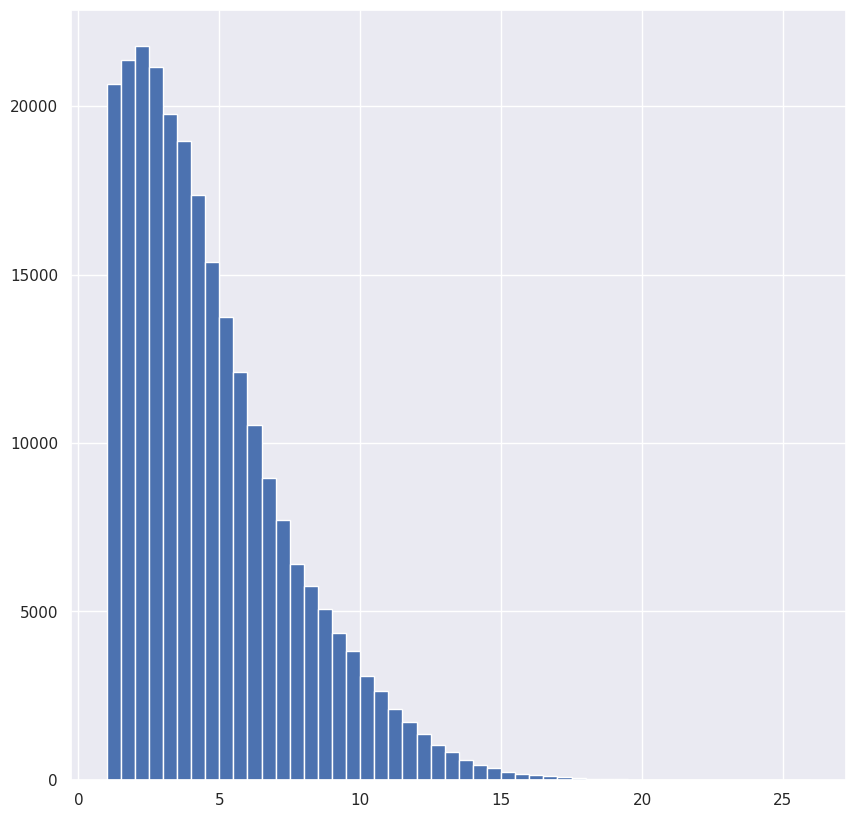

In [ ]:
sns.set()

# Построим гистограммы наших данных с числом бинов 50
df_0_mean['rn'].hist(bins=50, figsize=(10, 10))

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'rn'}>,
        <Axes: title={'center': 'pre_since_opened'}>,
        <Axes: title={'center': 'pre_since_confirmed'}>,
        <Axes: title={'center': 'pre_pterm'}>,
        <Axes: title={'center': 'pre_fterm'}>],
       [<Axes: title={'center': 'pre_till_pclose'}>,
        <Axes: title={'center': 'pre_till_fclose'}>,
        <Axes: title={'center': 'pre_loans_credit_limit'}>,
        <Axes: title={'center': 'pre_loans_next_pay_summ'}>,
        <Axes: title={'center': 'pre_loans_outstanding'}>,
        <Axes: title={'center': 'pre_loans_max_overdue_sum'}>],
       [<Axes: title={'center': 'pre_loans_credit_cost_rate'}>,
        <Axes: title={'center': 'pre_loans5'}>,
        <Axes: title={'center': 'pre_loans530'}>,
        <Axes: title={'center': 'pre_loans3060'}>,
        <Axes: title={'center': 'pre_loans6090'}>,
        <Axes: title={'center': 'pre_loans90'}>],
       [<Axes: title={'center': 'is_zero_loans5'}>,
      

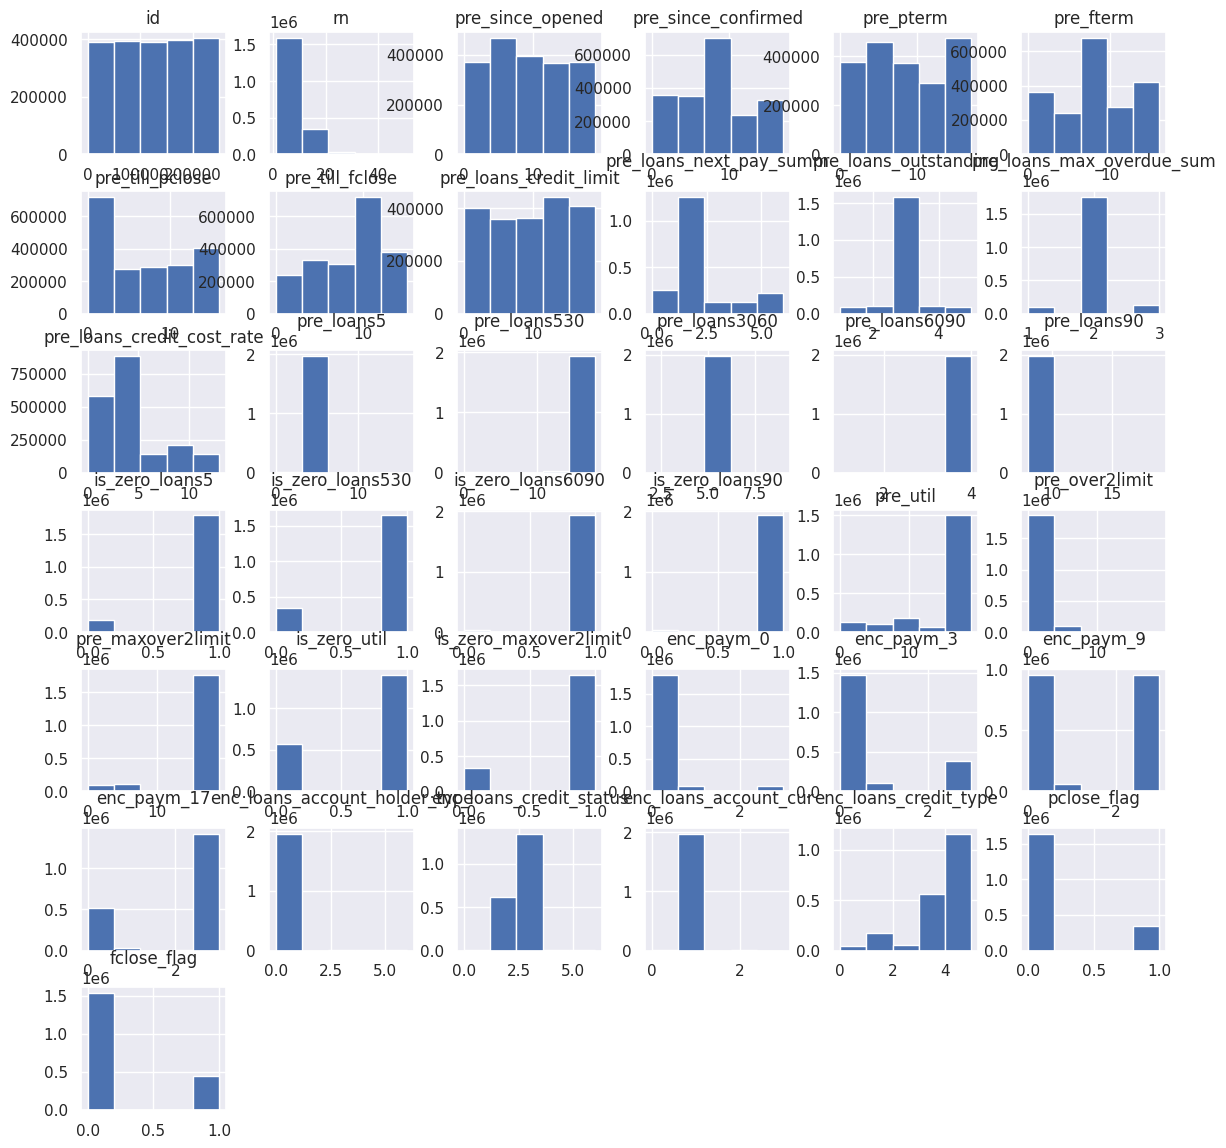

In [ ]:
df_0.hist(bins=5, figsize=(14, 14))

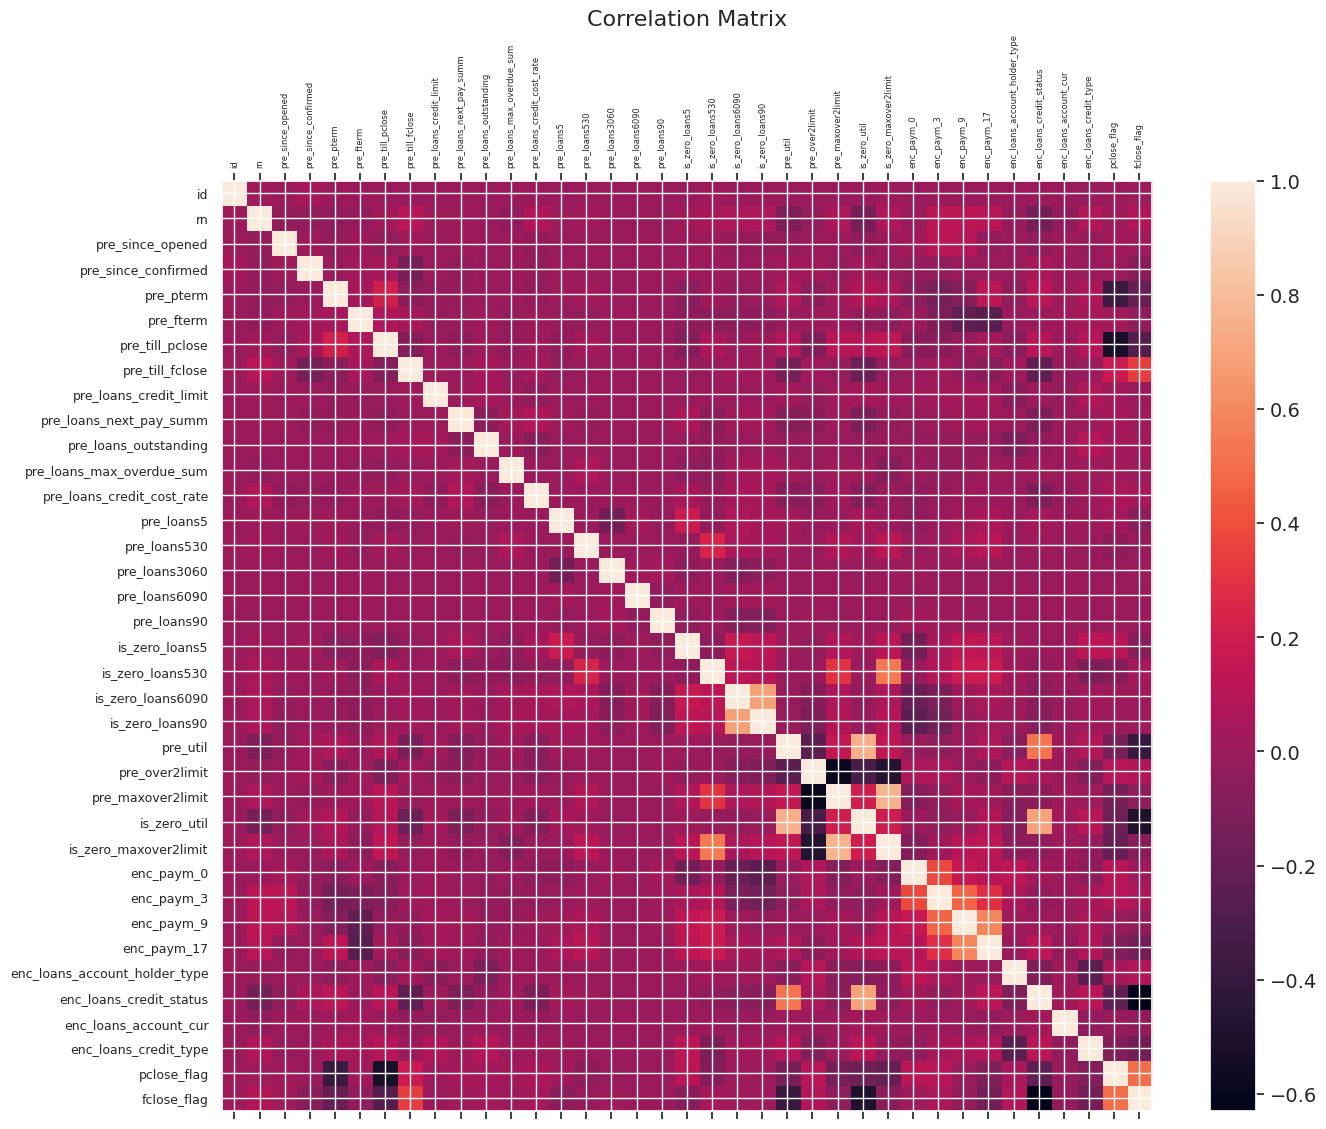

In [ ]:
f = plt.figure(figsize=(15, 12))
plt.matshow(df_0.corr(), fignum=f.number)
plt.xticks(range(df_0.select_dtypes(['number']).shape[1]), df_0.select_dtypes(['number']).columns, fontsize=6, rotation=90)
plt.yticks(range(df_0.select_dtypes(['number']).shape[1]), df_0.select_dtypes(['number']).columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

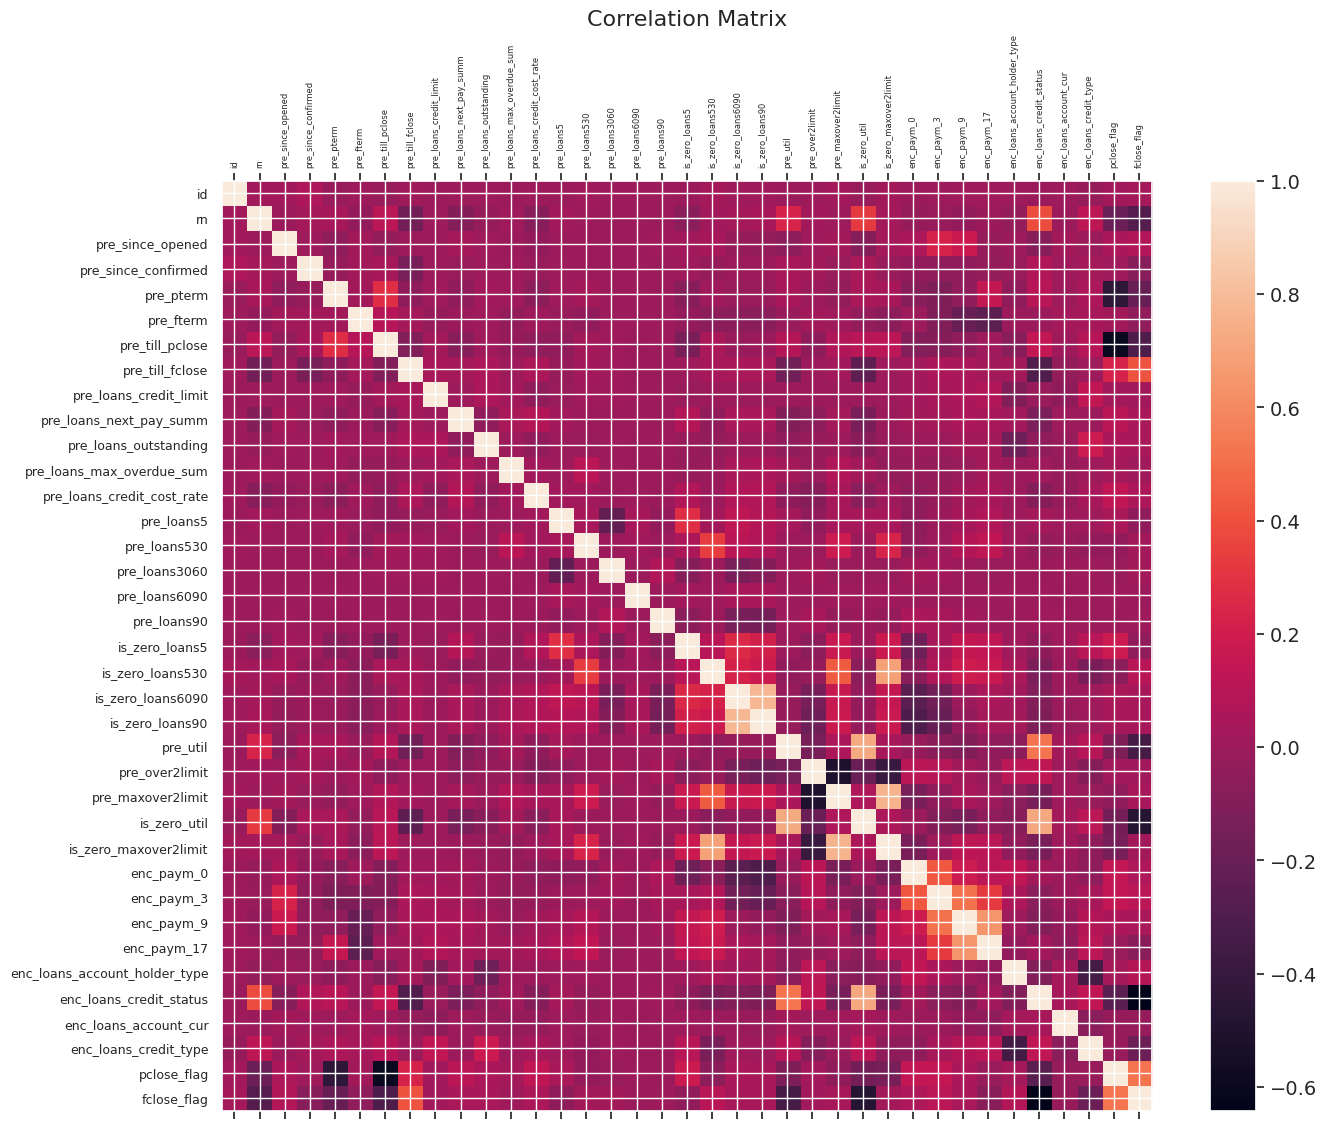

In [ ]:
f = plt.figure(figsize=(15, 12))
plt.matshow(df_0_mean.corr(), fignum=f.number)
plt.xticks(range(df_0_mean.select_dtypes(['number']).shape[1]), df_0_mean.select_dtypes(['number']).columns, fontsize=6, rotation=90)
plt.yticks(range(df_0_mean.select_dtypes(['number']).shape[1]), df_0_mean.select_dtypes(['number']).columns, fontsize=9)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
df_full = pd.concat([
    df_0_mean,
    df_1_mean,
    df_2_mean,
    df_3_mean,
    df_4_mean,
    df_5_mean,
    df_6_mean,
    df_7_mean,
    df_9_mean,
    df_9_mean,
    df_10_mean,
    df_11_mean,
    ], ignore_index=True)

In [ ]:
df_full

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
0,0,5.5,8.100000,7.600000,7.100000,7.500000,11.400000,10.700000,9.600000,3.100000,...,0.100000,0.600000,1.500000,2.100000,1.0,2.600000,1.0,3.500000,0.100000,0.200000
1,1,7.5,11.428571,7.642857,6.642857,7.928571,10.071429,7.000000,8.142857,2.142857,...,0.285714,0.642857,1.428571,2.142857,1.0,2.714286,1.0,3.142857,0.071429,0.142857
2,2,2.0,8.333333,10.666667,7.000000,6.000000,5.000000,9.000000,1.666667,1.333333,...,1.000000,1.000000,1.000000,2.333333,1.0,2.333333,1.0,3.333333,0.666667,0.666667
3,3,8.0,7.000000,7.333333,7.600000,7.800000,5.200000,8.133333,9.866667,2.600000,...,0.000000,0.200000,0.600000,1.600000,1.0,2.533333,1.0,3.600000,0.333333,0.400000
4,4,1.0,12.000000,9.000000,4.000000,8.000000,1.000000,11.000000,12.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,1.0,2.000000,1.0,3.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,6.0,8.818182,9.181818,8.909091,8.909091,8.818182,8.818182,7.363636,2.272727,...,0.363636,0.090909,0.636364,2.000000,1.0,2.545455,1.0,3.909091,0.181818,0.454545
2999996,2999996,7.0,8.000000,11.384615,9.000000,8.461538,6.307692,6.846154,11.615385,1.923077,...,0.153846,0.230769,0.923077,2.307692,1.0,2.692308,1.0,3.923077,0.384615,0.307692
2999997,2999997,5.5,8.100000,7.800000,8.500000,7.800000,8.200000,9.100000,7.000000,2.400000,...,0.100000,0.500000,0.700000,2.200000,1.0,2.500000,1.0,3.700000,0.100000,0.100000
2999998,2999998,3.0,11.600000,9.200000,7.800000,9.400000,6.000000,7.800000,11.400000,2.600000,...,0.600000,1.000000,3.000000,3.000000,1.0,2.400000,1.0,2.800000,0.400000,0.200000


In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/data/train_id_full.csv'

In [ ]:

with open(filename, 'w') as f:
  df_full.to_csv(f, index=False, header=False)



---



##Read prepared train file



---



In [ ]:
filename = '/content/drive/MyDrive/Colab Notebooks/data/train_id_full.csv'

In [ ]:
full_headers = []
for i in column_names:
  if not i in column_to_drop:
    full_headers.append(i)


In [ ]:
len(full_headers)

37

In [ ]:
train_full = pd.read_csv(
    filename,
    names=full_headers,
    header=None
)

In [ ]:
train_full

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
0,0,5.5,8.100000,7.600000,7.100000,7.500000,11.400000,10.700000,9.600000,3.100000,...,0.100000,0.600000,1.500000,2.100000,1.0,2.600000,1.0,3.500000,0.100000,0.200000
1,1,7.5,11.428571,7.642857,6.642857,7.928571,10.071429,7.000000,8.142857,2.142857,...,0.285714,0.642857,1.428571,2.142857,1.0,2.714286,1.0,3.142857,0.071429,0.142857
2,2,2.0,8.333333,10.666667,7.000000,6.000000,5.000000,9.000000,1.666667,1.333333,...,1.000000,1.000000,1.000000,2.333333,1.0,2.333333,1.0,3.333333,0.666667,0.666667
3,3,8.0,7.000000,7.333333,7.600000,7.800000,5.200000,8.133333,9.866667,2.600000,...,0.000000,0.200000,0.600000,1.600000,1.0,2.533333,1.0,3.600000,0.333333,0.400000
4,4,1.0,12.000000,9.000000,4.000000,8.000000,1.000000,11.000000,12.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,1.0,2.000000,1.0,3.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,2999995,6.0,8.818182,9.181818,8.909091,8.909091,8.818182,8.818182,7.363636,2.272727,...,0.363636,0.090909,0.636364,2.000000,1.0,2.545455,1.0,3.909091,0.181818,0.454545
2999996,2999996,7.0,8.000000,11.384615,9.000000,8.461538,6.307692,6.846154,11.615385,1.923077,...,0.153846,0.230769,0.923077,2.307692,1.0,2.692308,1.0,3.923077,0.384615,0.307692
2999997,2999997,5.5,8.100000,7.800000,8.500000,7.800000,8.200000,9.100000,7.000000,2.400000,...,0.100000,0.500000,0.700000,2.200000,1.0,2.500000,1.0,3.700000,0.100000,0.100000
2999998,2999998,3.0,11.600000,9.200000,7.800000,9.400000,6.000000,7.800000,11.400000,2.600000,...,0.600000,1.000000,3.000000,3.000000,1.0,2.400000,1.0,2.800000,0.400000,0.200000




---



##Train Target Data



---



In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_target.csv')

In [ ]:
# Посмотрим на соотношение классов в нашем датасете
len_0 = len(df_train[df_train['flag'] == 0])
len_1 = len(df_train[df_train['flag'] == 1])
print(f"Всего класса 0 в датасете: {len_0}, а класса 1: {len_1}")
print(len_1/(len_0 + len_1) * 100, '%')

Всего класса 0 в датасете: 2893558, а класса 1: 106442
3.5480666666666667 %


In [ ]:
df_train.hist(bins=50, figsize=(10, 10), column='flag')

In [ ]:
df_train.value_counts()

id       flag
0        0       1
1999993  0       1
1999995  0       1
1999996  0       1
1999997  0       1
                ..
1000001  0       1
1000002  0       1
1000003  0       1
1000004  0       1
2999999  0       1
Name: count, Length: 3000000, dtype: int64



---



##Test Data



---



In [ ]:
df_test_0 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/test_data_0.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_test_0 = df_test_0.drop(columns=column_to_drop)

In [ ]:
df_test_0_mean = df_test_0.groupby('id').mean().reset_index()

In [ ]:
df_test_0_mean

In [ ]:
df_test_1 = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/data/test_data_1.pq',
                     engine='auto',
                     columns=column_names,
                     use_threads=True,
                     )

In [ ]:
df_test_1

In [ ]:
df_test_1 = df_test_1.drop(columns=column_to_drop)

In [ ]:
df_test_1_mean = df_test_1.groupby('id').mean().reset_index()

In [ ]:
df_test_full = pd.concat([
   df_test_0_mean,
   df_test_1_mean
    ], ignore_index=True)

In [ ]:
df_test_full

In [ ]:
filename_test = '/content/drive/MyDrive/Colab Notebooks/data/test_id_full.csv'

In [ ]:
with open(filename_test, 'w') as f:
  df_test_full.to_csv(f, index=False, header=False)



---



##Read prepared test file



---



In [ ]:
filename_test = '/content/drive/MyDrive/Colab Notebooks/data/test_id_full.csv'

In [ ]:
test_full = pd.read_csv(
    filename_test,
    names=full_headers,
    header=None
)

In [ ]:
test_full

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_0,enc_paym_3,enc_paym_9,enc_paym_17,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_account_cur,enc_loans_credit_type,pclose_flag,fclose_flag
0,3000000,1.5,15.000000,10.500000,16.000000,11.500000,12.000000,11.000000,9.500000,2.500000,...,0.000000,0.000000,1.500000,3.000000,1.0,2.500000,1.0,4.000000,0.000000,0.000000
1,3000001,5.5,10.800000,8.700000,8.800000,6.400000,7.200000,10.000000,7.100000,2.100000,...,0.200000,0.500000,1.500000,2.100000,1.0,2.700000,1.0,3.600000,0.200000,0.300000
2,3000002,2.5,8.250000,12.500000,9.500000,8.250000,4.500000,4.250000,6.000000,2.000000,...,0.000000,0.750000,1.500000,3.000000,1.0,2.750000,1.0,3.750000,0.000000,0.000000
3,3000003,5.0,7.777778,12.222222,6.555556,7.444444,7.333333,10.666667,8.666667,2.444444,...,0.333333,1.666667,2.000000,2.666667,1.0,2.777778,1.0,3.777778,0.111111,0.222222
4,3000004,11.0,9.523810,8.857143,8.761905,8.000000,7.095238,7.476190,9.809524,3.047619,...,0.142857,0.476190,1.333333,2.523810,1.0,2.809524,1.0,3.809524,0.047619,0.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3499995,3.0,7.600000,9.000000,8.600000,10.800000,5.200000,7.400000,10.000000,1.800000,...,0.600000,1.400000,1.400000,2.400000,1.0,2.600000,1.0,5.000000,0.400000,0.400000
499996,3499996,2.5,8.500000,8.250000,7.000000,3.000000,0.750000,5.500000,6.250000,2.750000,...,0.000000,1.500000,1.750000,3.000000,1.0,2.250000,1.0,2.500000,0.000000,0.000000
499997,3499997,5.0,12.222222,10.000000,6.333333,8.222222,6.000000,9.888889,12.000000,2.222222,...,1.000000,1.333333,2.000000,2.333333,1.0,2.777778,1.0,3.666667,0.333333,0.444444
499998,3499998,1.5,11.000000,8.000000,8.500000,8.500000,14.000000,8.000000,5.500000,1.000000,...,0.000000,1.500000,1.500000,1.500000,1.0,2.000000,1.0,3.500000,0.000000,0.000000




---



##Test Target Data



---



In [ ]:
df_test_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/test_target.csv')

In [ ]:
df_test_target

,id
0,3000000
1,3000001
2,3000002
3,3000003
4,3000004
...,...
499995,3499995
499996,3499996
499997,3499997
499998,3499998




---



##Model Regression



---



In [ ]:
X_train = train_full
y_train = df_train['flag']
X_test = test_full
y_test = df_train['flag'][:500000]

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3000000, 37) (500000, 37) (3000000,) (500000,)


In [ ]:
# Импортируем логистическую регрессию из модуля linear_model библиотеки sklearn
from sklearn.linear_model import LogisticRegression

In [ ]:
# Содадим объект класса LogisticRegression с параметрами по умолчанию
model_LR = LogisticRegression()

# Обучим его на обучающем датасете
model_LR.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Получим предсказания и посмотрим на долю правильных ответов:
y_pred_test_LR = model_LR.predict(X_test)

print(f"Доля врено угаданных объектов {(y_pred_test_LR == y_test).sum() / len(y_test)}")

Доля врено угаданных объектов 0.968108


In [ ]:
len(y_pred_test_LR)

500000

In [ ]:
# Импортируем класс StandardScaler из модуля preprocessing библиотеки sklearn
from sklearn.preprocessing import StandardScaler

In [ ]:
# Отмасштабируем наши признаки
# Создадим объект класса StandardScaler

scaler = StandardScaler()

# Сделаем .fit() на обучении
scaler.fit(X_train) # считает среднее по выборке и std

StandardScaler()

In [ ]:
# .transform() на обучении и тесте (возвращает numpy, поэтому надо самим конвертировать обратно в dataframe с нужными индексами колонками)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [ ]:
# Построим логистическую регрессию на новых данных

# Содадим объект класса LogisticRegression с параметрами по умолчанию
model_LR = LogisticRegression()

# Обучим его на обучающем датасете
model_LR.fit(X_train, y_train)

# Получим предсказания и посмотрим на долю правильных ответов:
y_pred_test_LR = model_LR.predict(X_test)
y_pred_train_LR = model_LR.predict(X_train)

print(f"Доля верно угаданных объектов {(y_pred_train_LR == y_train).sum() / len(y_train)}")
print(f"Доля верно угаданных объектов {(y_pred_test_LR == y_test).sum() / len(y_test)}")

Доля верно угаданных объектов 0.9644736666666667
Доля верно угаданных объектов 0.967976


Выросла точность?)

In [ ]:
# импортируем функцию confusion_matrix из модуля metrics библиотеки sklearn
from sklearn.metrics import confusion_matrix

# Для нашей задачи матрица ошибок
mp_mtx = confusion_matrix(y_test, y_pred_test_LR)
font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
plt.rc('font', **font)
fig = plt.figure(figsize=(10,8))
sns.heatmap(mp_mtx, annot=True, fmt="d",
            xticklabels=df_train['flag'].unique(),
            yticklabels=df_train['flag'].unique())
plt.ylabel("Real value")
plt.xlabel("Predicted value")

In [ ]:
# В библиотеки sklearn эта метрика
from sklearn.metrics import accuracy_score

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print(f"TEST:  Accuracy -- {accuracy_score(y_test, y_pred_test_LR)}")
print(f"TRAIN: Accuracy -- {accuracy_score(y_train, y_pred_train_LR)}")

TEST:  Accuracy -- 0.967976
TRAIN: Accuracy -- 0.9644736666666667


In [ ]:
# В библиотеки sklearn эта метрика
from sklearn.metrics import precision_score

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print(f"TEST:  Precision -- {precision_score(y_test, y_pred_test_LR)}")
print(f"TRAIN: Precision -- {precision_score(y_train, y_pred_train_LR)}")

TEST:  Precision -- 0.02857142857142857
TRAIN: Precision -- 0.13756613756613756


In [ ]:
# В библиотеки sklearn эта метрика
from sklearn.metrics import recall_score

# Посчитаем для нашей модели на обучающем и тестировочном кусках
print(f"TEST:  Recall -- {recall_score(y_test, y_pred_test_LR)}")
print(f"TRAIN: Recall -- {recall_score(y_train, y_pred_train_LR)}")

TEST:  Recall -- 0.00012542330364981815
TRAIN: Recall -- 0.00024426448206535015




---



##KNN



---



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
y_pred_train_KNN = model_knn.predict(X_train)

In [ ]:
y_pred_test_KNN  = model_knn.predict(X_test)

In [ ]:


# Посмотрим accuracy на обучении и на тесте
print(f"TEST:  Accuracy -- {accuracy_score(y_test, y_pred_test_KNN)}")
print(f"TRAIN: Accuracy -- {accuracy_score(y_train, y_pred_train_KNN)}")



---



##Установка CatBoost



---



In [ ]:
!pip install catboost

In [ ]:
import catboost as cb

In [ ]:
CB_model = cb.CatBoostClassifier()
CB_model.fit(X_train, y_train)

In [ ]:

# Получим предсказания для обучающего и тестового датасета
y_pred_train_CB = CB_model.predict(X_train)
y_pred_test_CB  = CB_model.predict(X_test)

# Посмотрим accuracy на обучении и на тесте
print(f"TEST:  Accuracy -- {accuracy_score(y_test, y_pred_test_CB)}")
print(f"TRAIN: Accuracy -- {accuracy_score(y_train, y_pred_train_CB)}")

TEST:  Accuracy -- 0.967652
TRAIN: Accuracy -- 0.9650986666666667


In [ ]:
# В библиотеки sklearn эта метрика
from sklearn.metrics import f1_score

# Посчитаем для нашей модели knn на обучающем и тестировочном кусках
print(f"TEST:  F1 -- {f1_score(y_test, y_pred_test_CB)}")
print(f"TRAIN: F1 -- {f1_score(y_train, y_pred_train_CB)}")

TEST:  F1 -- 0.0008648381517173216
TRAIN: F1 -- 0.033293324716092705


### `ROC-AUC`

`ROC-AUC` или *площадь под ROC кривой* -- это *мера показывающая насколько точно упорядочены элементы выборки по своим скорам*.

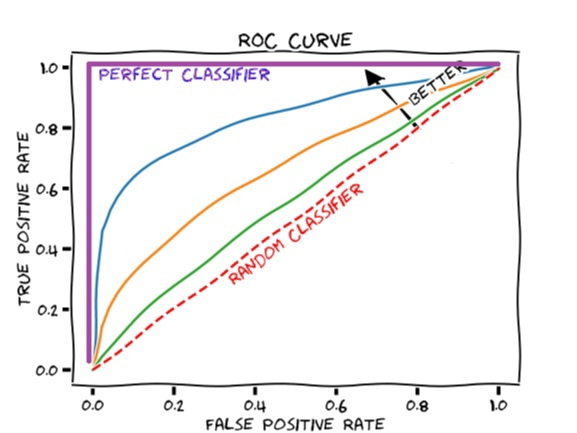

In [ ]:
len(y_pred_test_CB)

500000

In [ ]:
# В библиотеки sklearn эта метрика
from sklearn.metrics import roc_auc_score

# Посмотрим эту метрику и для логистической регрессии и для knn (несмотря на то, что мы опустили алгоримт нахождения вероятностей для knn)

# Для ROC-AUC нам нужны вероятности принадлежности положительному классу
# Для получения вероятностей воспользуемся методом predict_proba и нам нужен второй столбец
y_pred_prob_test_LR = model_LR.predict_proba(X_test)[:, 1]
y_pred_prob_test_CB = CB_model.predict_proba(X_test)[:, 1]
y_pred_prob_train_LR = model_LR.predict_proba(X_train)[:, 1]
y_pred_prob_train_CB = CB_model.predict_proba(X_train)[:, 1]

# Посчитаем для нашей модели knn на обучающем и тестировочном кусках
print("Logistic Regression")
print(f"TEST:  ROC-AUC -- {roc_auc_score(y_test, y_pred_prob_test_LR)}")
print(f"TRAIN: ROC-AUC -- {roc_auc_score(y_train, y_pred_prob_train_LR)}")
print("Catboost")
print(f"TEST:  ROC-AUC -- {roc_auc_score(y_test, y_pred_prob_test_CB)}")
print(f"TRAIN: ROC-AUC -- {roc_auc_score(y_train, y_pred_prob_train_CB)}")

Logistic Regression
TEST:  ROC-AUC -- 0.4988885134647711
TRAIN: ROC-AUC -- 0.5342920324533015
Catboost
TEST:  ROC-AUC -- 0.4985380305844302
TRAIN: ROC-AUC -- 0.7464054822570356


In [ ]:
len(y_pred_prob_test_CB)

500000

In [ ]:
y_pred_prob_test_CB

array([0.01980782, 0.06640536, 0.01723509, ..., 0.04436576, 0.04453241,
       0.03135438])

In [ ]:
len(y_pred_prob_test_LR)

500000

In [ ]:
y_pred_prob_test_LR

array([0.01972743, 0.04038455, 0.03833245, ..., 0.03246991, 0.03576423,
       0.03314762])

In [ ]:
y_test = y_pred_test_CB

In [ ]:
# заодно построим ROC-кривую. Это наглядный способ понять как хорошо работает алгоритм
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_test_LR)
fpr_cb, tpr_cb, _ = roc_curve(y_test, y_pred_prob_test_CB)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_cb, tpr_cb, label="CB")
plt.title(f'ROC AUC = {round(auc(fpr_lr, tpr_lr),2)}|{round(auc(fpr_cb, tpr_cb), 2)}')
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)
plt.legend()
plt.show()

In [ ]:
df_test_target['score'] = y_pred_prob_test_CB

In [ ]:
df_test_target

In [ ]:
filename_target = '/content/drive/MyDrive/Colab Notebooks/data/target.csv'

In [ ]:
with open(filename_target, 'w') as f:
  df_test_target.to_csv(f, index=False)